# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch.

## Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно.
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import time

Загрузка и проверка корректности данных

In [12]:
path = './data'

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

Files already downloaded and verified
Files already downloaded and verified


In [16]:
def denormalize(image):
    image = image * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return image

def plot_images(dataset, title):
    vert_size = 10
    horiz_size = 10
    fig, axes = plt.subplots(vert_size, horiz_size, figsize = (12, 12))
    fig.suptitle(title)

    count_images = vert_size * horiz_size
    indices = torch.randperm(len(dataset))[:count_images]
    for number in range(count_images):
        i = number // horiz_size
        j = number % horiz_size

        image = denormalize(dataset[indices[number]][0])
        image = image.numpy().transpose(1, 2, 0)
        axes[i, j].imshow(image, cmap=plt.cm.binary)
        axes[i, j].set_title('Label: ' + class_names[int(dataset[indices[number]][1])], fontsize = 10)
        axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

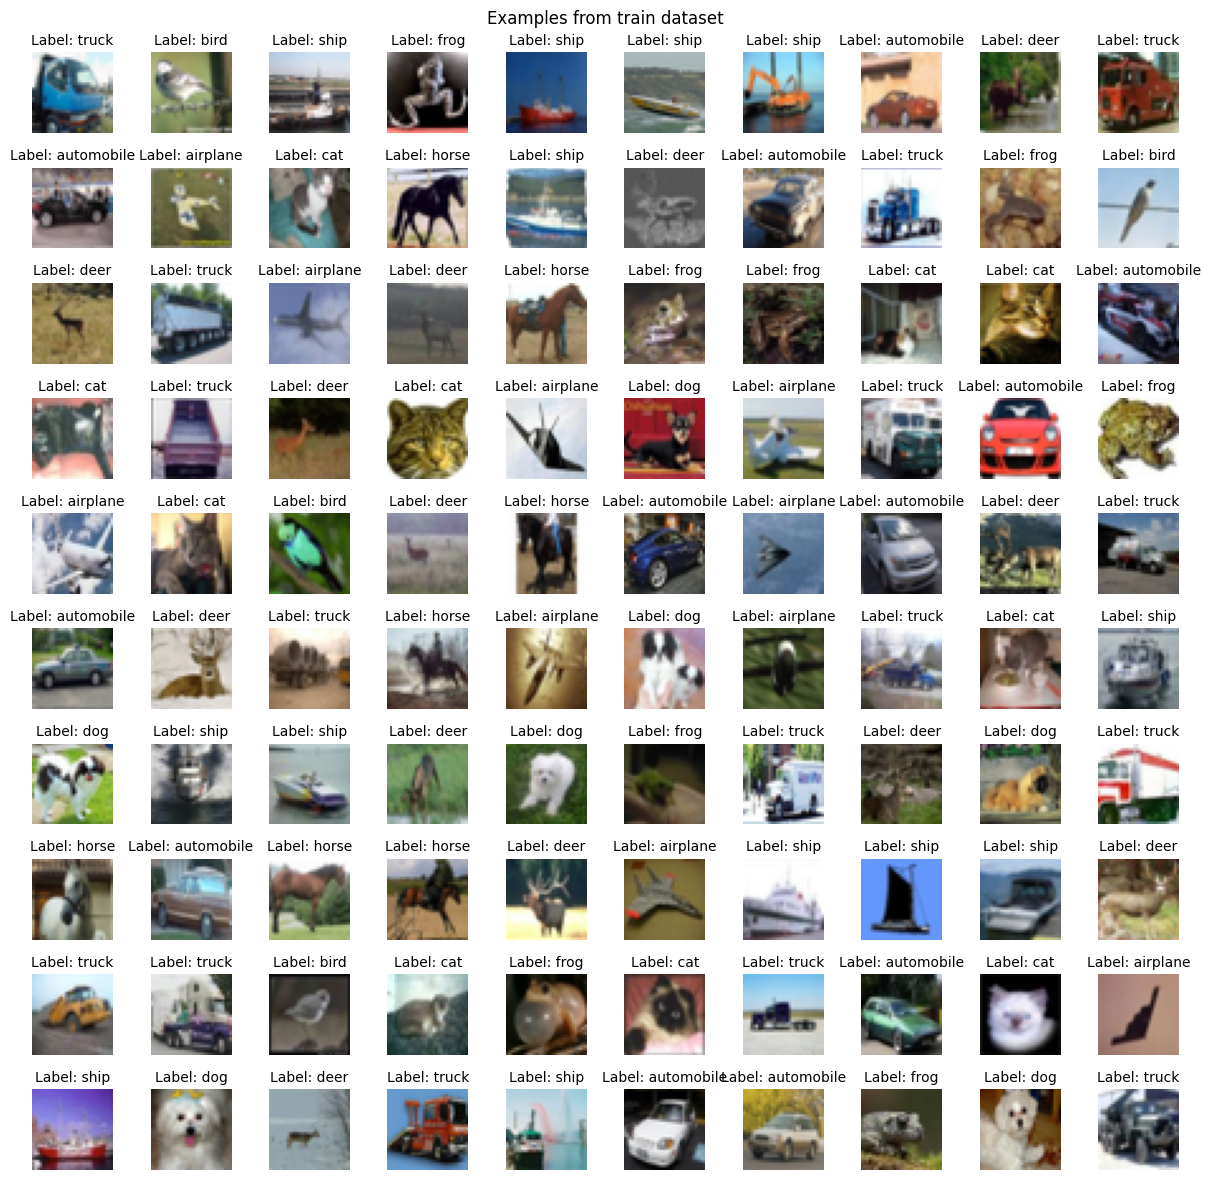

In [17]:
plot_images(train_dataset, 'Examples from train dataset')

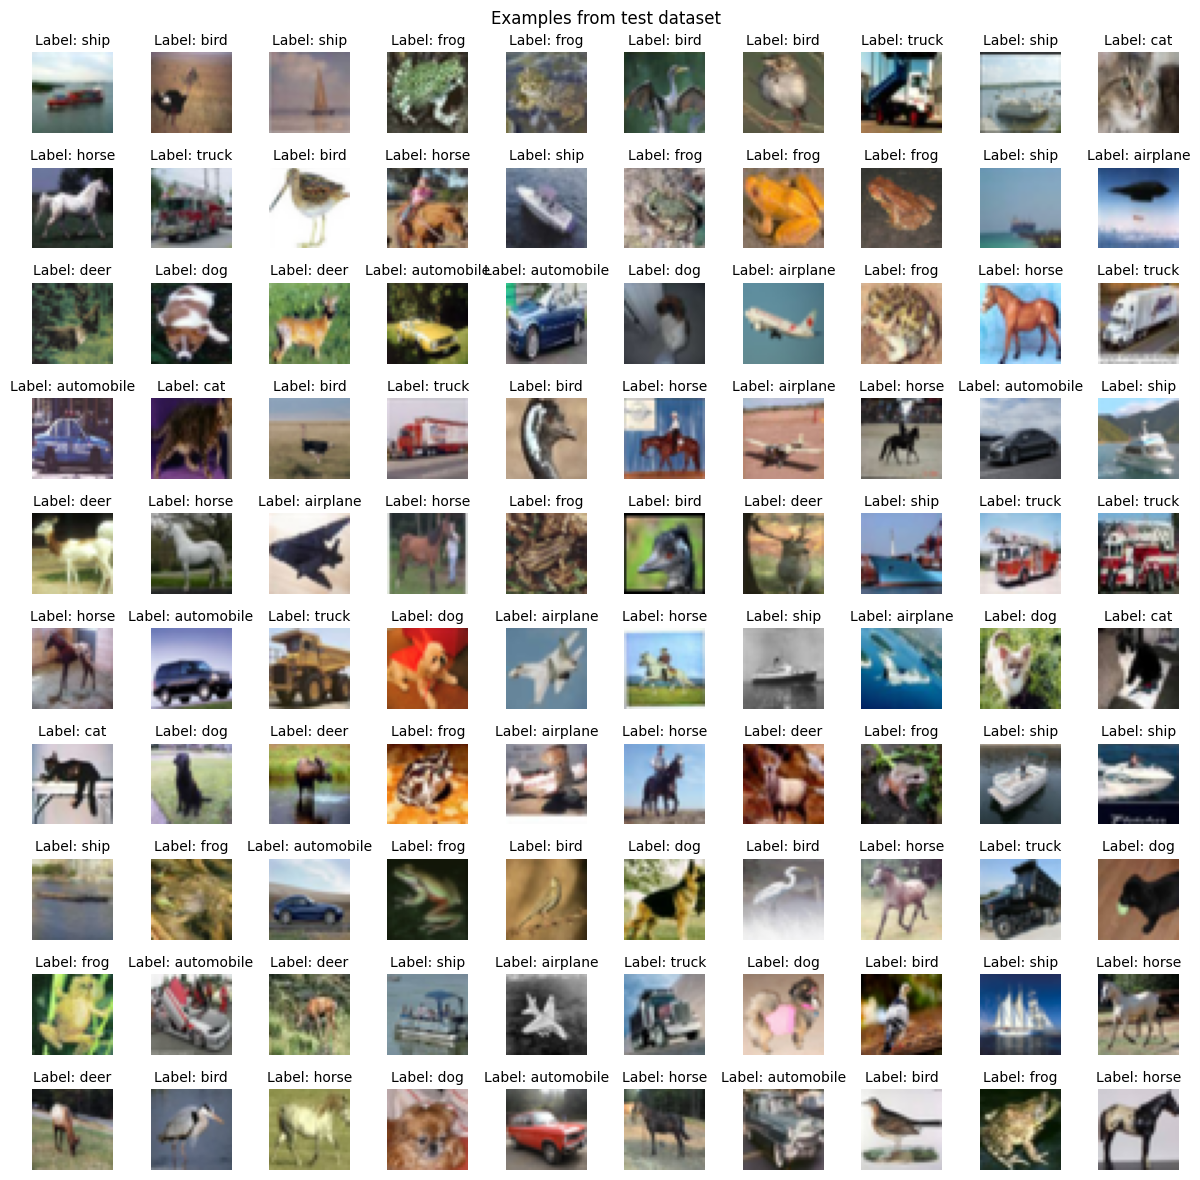

In [18]:
plot_images(test_dataset, 'Examples from test dataset')

In [19]:
print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')

Size of train dataset: 50000
Size of test dataset: 10000


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


Гиперпараметры обучения

In [21]:
learning_rate = 0.001
epochs = 20
batch_size = 64

Разбиение датасетов на батчи

In [22]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

Реализация сверточной нейронной сети

In [50]:
def conv_block(input_channels, output_channels, pool):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(output_channels),
              nn.ReLU()]

    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

class CustomConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CustomConvolutionalNeuralNetwork, self).__init__()

        self.first_block = nn.Sequential(conv_block(input_channels, 64, False),
                                         conv_block(64, 64, False),
                                         conv_block(64, 128, True),
                                         conv_block(128, 128, False),
                                         conv_block(128, 256, True),
                                         conv_block(256, 256, False),
                                         conv_block(256, 512, True),
                                         conv_block(512, 512, False)
        )

        self.second_block = nn.Sequential(nn.MaxPool2d(4),
                                          nn.Flatten(),
                                          nn.Dropout(0.2),
                                          nn.Linear(512, output_channels)
        )

    def forward(self, x):
        out = self.first_block(x)
        out = self.second_block(out)
        return out

    def fit(self, data_loader, loss_function, optimizer):
        accuracy_list = []
        loss_list = []

        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = self.forward(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accuracy_list.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))
            loss_list.append(loss)

        accuracy_mean = torch.stack(accuracy_list).mean()
        loss_mean = torch.stack(loss_list).mean()

        return accuracy_mean.cpu().detach().numpy(), loss_mean.cpu().detach().numpy()

    def predict(self, data_loader):
      tp = 0
      n = 0

      with torch.no_grad():
          for images, labels in data_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = self.forward(images)

              predicted = torch.argmax(outputs, dim=1)

              n += labels.size(dim=0)
              tp += (predicted == labels).sum()

      return (tp / n).item()

In [51]:
input_channels = 3
output_channels = 10

cnn_model = CustomConvolutionalNeuralNetwork(input_channels, output_channels).to(device)
cross_entropy_loss = nn.CrossEntropyLoss().to(device)
optimizer_adam = optim.Adam(cnn_model.parameters(), lr = learning_rate)

summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

Демонстрация работы нейронной сети

In [52]:
error_train_list = []
accuracy_train_list = []

for epoch in range(epochs):
    start_time = time.time()
    accuracy_train, error_train = cnn_model.fit(train_data_loader, cross_entropy_loss, optimizer_adam)
    finish_time = time.time()

    error_train_list.append(error_train)
    accuracy_train_list.append(accuracy_train)

    total_time = finish_time - start_time
    print(f"Epoch: {epoch + 1}/{epochs}, error: {error_train:.4f}, accuracy: {accuracy_train:.4f}, time: {total_time:.2f}")

Epoch: 1/20, error: 1.1463, accuracy: 0.5912, time: 25.40
Epoch: 2/20, error: 0.6811, accuracy: 0.7651, time: 24.49
Epoch: 3/20, error: 0.5150, accuracy: 0.8226, time: 24.09
Epoch: 4/20, error: 0.4073, accuracy: 0.8599, time: 24.23
Epoch: 5/20, error: 0.3239, accuracy: 0.8870, time: 24.30
Epoch: 6/20, error: 0.2435, accuracy: 0.9144, time: 24.42
Epoch: 7/20, error: 0.1908, accuracy: 0.9327, time: 24.45
Epoch: 8/20, error: 0.1466, accuracy: 0.9473, time: 24.51
Epoch: 9/20, error: 0.1046, accuracy: 0.9631, time: 24.65
Epoch: 10/20, error: 0.0878, accuracy: 0.9689, time: 24.89
Epoch: 11/20, error: 0.0691, accuracy: 0.9760, time: 25.02
Epoch: 12/20, error: 0.0681, accuracy: 0.9756, time: 24.69
Epoch: 13/20, error: 0.0568, accuracy: 0.9802, time: 24.68
Epoch: 14/20, error: 0.0495, accuracy: 0.9829, time: 24.72
Epoch: 15/20, error: 0.0517, accuracy: 0.9824, time: 24.75
Epoch: 16/20, error: 0.0366, accuracy: 0.9875, time: 24.77
Epoch: 17/20, error: 0.0411, accuracy: 0.9855, time: 24.76
Epoch:

Графики ошибки и точности

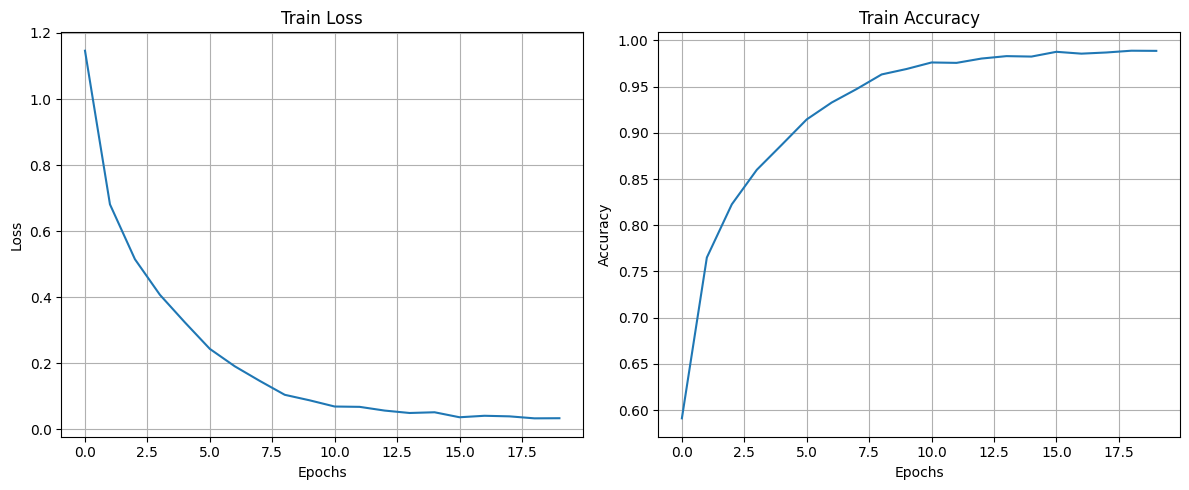

In [53]:
fig, (axe1, axe2) = plt.subplots(1, 2, figsize=(12, 5))

axe1.plot(error_train_list)
axe1.set_xlabel('Epochs')
axe1.set_ylabel('Loss')
axe1.set_title('Train Loss')
axe1.grid(True)

axe2.plot(accuracy_train_list)
axe2.set_xlabel('Epochs')
axe2.set_ylabel('Accuracy')
axe2.set_title('Train Accuracy')
axe2.grid(True)

plt.tight_layout()
plt.show()

In [54]:
accuracy = cnn_model.predict(test_data_loader)
print(f'Test accuracy = {accuracy:.4f}')

Test accuracy = 0.8760
